** Summary **
This dataset (ml-latest) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. 

It contains 27753444 ratings and 1108997 tag applications across 58098 movies. 

These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. 

No demographic information is included. 

Each user is represented by an id, and no other information is provided.

The data are contained in the files 

    genome-scores.csv, 
    genome-tags.csv, 
    links.csv, 
    movies.csv, 
    ratings.csv and 
    tags.csv. 
    
More details about the contents and use of all these files follows.

This and other GroupLens data sets are publicly available for download at http://grouplens.org/datasets/.

# Ratings Data File Structure (ratings.csv)
All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,
    movieId,
    rating,
    timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

# Tags Data File Structure (tags.csv)
All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId, 
    movieId, 
    tag, 
    timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

# Movies Data File Structure (movies.csv)
Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

    movieId,
    title,
    genres
    
Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

    Action
    Adventure
    Animation
    Children's
    Comedy
    Crime
    Documentary
    Drama
    Fantasy
    Film-Noir
    Horror
    Musical
    Mystery
    Romance
    Sci-Fi
    Thriller
    War
    Western
    (no genres listed)

In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
# pip install fuzzywuzzy
# pip install python-Levenshtein (  Microsoft Visual C++ 14.0 is required)
# OR
# conda install -c conda-forge python-levenshtein

from fuzzywuzzy import fuzz
import Levenshtein as lev

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# FuzzyWuzzy Python library
FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. Basically it uses __Levenshtein Distance__ to calculate the differences between sequences.

In [2]:
fuzz.ratio('data science', 'database') 

60

In [3]:
Str1 = "Apple Inc."
Str2 = "Apple Inc."
Result = Str1 == Str2
print(Result)

True


In [4]:
Str1 = "Apple Inc."
Str2 = "apple Inc."
Result = Str1 == Str2
print(Result)

False


In this case, the variable Result will print True since the strings are an exact match (100% similarity), but see what happens if the case of Str2 changes:

In [5]:
Str1 = "Apple Inc."
Str2 = "apple Inc."
Result = Str1.lower() == Str2.lower()
print(Result)

True


In [6]:
Str1 = "Apple Inc."
Str2 = "apple Inc"
Result = Str1.lower() == Str2.lower()
print(Result)

False


Situations like the one above can, at times, appear on databases that have been created based on human data entry and in these cases we need more powerful tools to compare strings. One of these tools is called the __Levenshtein distance.__

# The Levenshtein Distance
The Levenshtein distance is a metric to measure how apart are two sequences of words. In other words, it measures the minimum number of edits that you need to do to change a one-word sequence into the other. These edits can be insertions, deletions or substitutions. This metric was named after Vladimir Levenshtein, who originally considered it in 1965.

In [18]:
Str1 = "Apple Inc.."
Str2 = "apple Inc"

Distance = lev.distance(Str1.lower(),Str2.lower()),
print(Distance)

Ratio = lev.ratio(Str1.lower(),Str2.lower())
print(Ratio)

(2,)
0.9


In [6]:
Str1 = "Apple Inc."
Str2 = "apple Inc"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
print(Ratio)

95


In [15]:
Str1 = "Los Angeles Lakers"
Str2 = "Lakers"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
print(Ratio)
print(Partial_Ratio)

50
100


In [8]:
Str1 = "united states v. nixon"
Str2 = "Nixon v. United States"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
Token_Sort_Ratio = fuzz.token_sort_ratio(Str1,Str2)
print(Ratio)
print(Partial_Ratio)
print(Token_Sort_Ratio)

59
74
100


In [9]:
# environment variables 
env_var = os.environ 
env_var['DATA_PATH']

'E:\\MYLEARN\\2-ANALYTICS-DataScience\\datasets'

# 1. Load Data

In [10]:
# data location
#data_path = os.path.join(os.environ['DATA_PATH'], 'ml-latest-small')
data_path = os.environ['DATA_PATH']
data_path

'E:\\MYLEARN\\2-ANALYTICS-DataScience\\datasets'

In [11]:
# small
# movies_filename  = 'small-movies.csv'
# ratings_filename = 'small-ratings.csv'

# 1 million
# movies_filename  = '1m-movies.dat'
# ratings_filename = '1m-ratings.dat'
# users_filename   = '1m-users.dat'

# 10 million
movies_filename  = '10m-movies.dat'
ratings_filename = '10m-ratings.dat'


In [12]:
df_movies   = pd.read_csv(os.path.join(data_path, movies_filename), 
                          names=['movie_id', 'title', 'genre'], 
                          sep='::', 
                          engine='python')

df_ratings  = pd.read_csv(os.path.join(data_path, ratings_filename), 
                          names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                          sep='::', 
                          engine='python')

# df_users    = pd.read_csv(os.path.join(data_path, users_filename), 
#                           names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], 
#                           sep='::', 
#                           engine='python')


In [13]:
print(df_movies.info())
print(df_ratings.info())

# print(df_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 3 columns):
movie_id    10681 non-null int64
title       10681 non-null object
genre       10681 non-null object
dtypes: int64(1), object(2)
memory usage: 250.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000054 entries, 0 to 10000053
Data columns (total 4 columns):
user_id      int64
movie_id     int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


In [16]:
df_movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [18]:
num_users   = len(df_ratings.user_id.unique())
num_items   = len(df_ratings.movie_id.unique())
num_ratings = len(df_ratings)

print('There are {} unique users, {} unique movies and {} ratings, in this data set'.format(num_users, num_items, num_ratings))

There are 69878 unique users, 10677 unique movies and 10000054 ratings, in this data set


In [19]:
# df_users.head()

# Exploratory data analysis

Plot the counts of each rating

Plot rating frequency of each movie

### 1. rating distribution

In [20]:
df_ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [21]:
# Calculate ratings count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,94988
1.0,384180
1.5,118278
2.0,790306
2.5,370178
3.0,2356676
3.5,879764
4.0,2875850
4.5,585022


The table does not include counts of zero rating score. 

Text(0, 0.5, 'number of ratings')

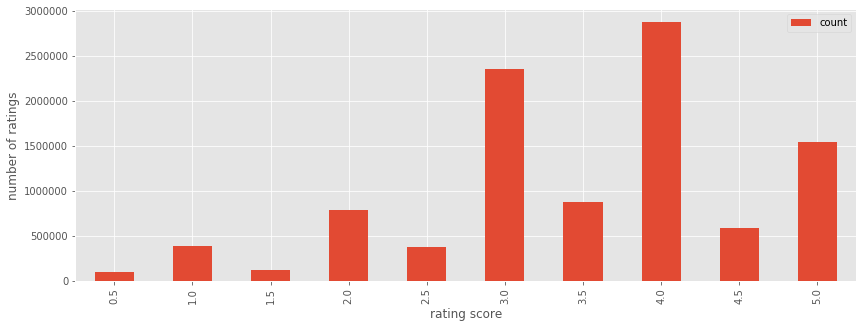

In [22]:
ax = df_ratings_cnt_tmp.plot(y='count',
                             kind='bar',
                             figsize=(14, 5), 
                             use_index=True
                            );

ax.set_xlabel("rating score")
ax.set_ylabel("number of ratings")

In [23]:
# there are a lot more counts in rating of zero
total_cnt       = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

rating_zero_cnt

736087352

### 2.  Plot rating frequency of all movies

In [24]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movie_id').size(), columns=['count'])
df_movies_cnt.sample(5)

,count
movie_id,
62299,6
1293,5140
3971,92
2097,864
33644,56


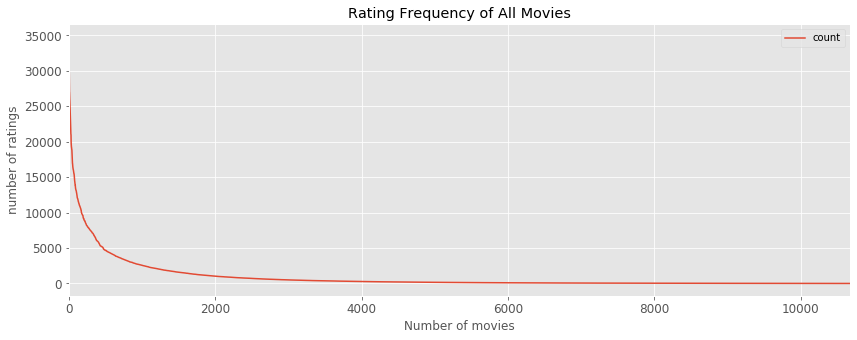

In [25]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(14, 5),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("Number of movies")
ax.set_ylabel("number of ratings");

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the __long-tail__ property. 

According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items.

plot the same distribution with __log scale__

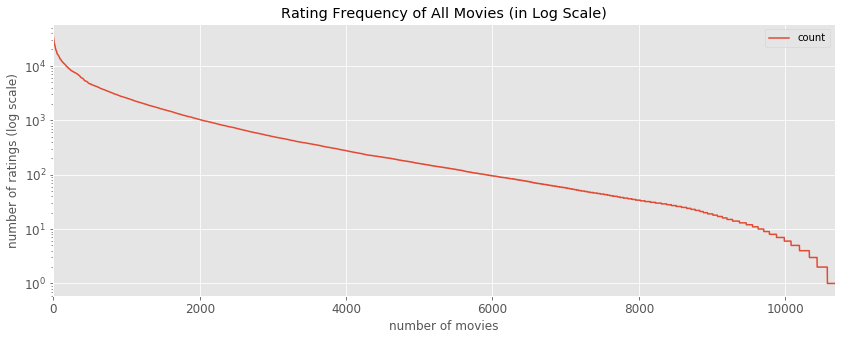

In [26]:
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(14, 5),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("number of movies")
ax.set_ylabel("number of ratings (log scale)");

- roughly 10,000 out of 53,889 movies are rated more than 100 times. 

- roughly 20,000 out of 53,889 movies are rated less than only 10 times. 

Let's look closer by displaying top quantiles of rating counts

In [27]:
s = pd.Series(np.arange(30))


In [28]:
s.quantile(np.linspace(.1, 1, 10))

0.1     2.9
0.2     5.8
0.3     8.7
0.4    11.6
0.5    14.5
0.6    17.4
0.7    20.3
0.8    23.2
0.9    26.1
1.0    29.0
dtype: float64

In [29]:
# df_movies_cnt['count'].quantile(np.arange(1, 0.4, -0.05))
df_movies_cnt['count'].quantile(np.arange(.50, 1, .01))

0.50      135.00
0.51      142.00
0.52      151.00
0.53      159.00
0.54      169.00
0.55      178.00
0.56      189.00
0.57      201.00
0.58      211.00
0.59      222.00
0.60      233.00
0.61      250.00
0.62      266.00
0.63      283.00
0.64      303.64
0.65      321.00
0.66      345.00
0.67      366.92
0.68      388.00
0.69      412.44
0.70      444.00
0.71      471.96
0.72      504.00
0.73      543.00
0.74      584.24
0.75      626.00
0.76      677.00
0.77      737.00
0.78      793.28
0.79      854.04
0.80      926.00
0.81     1002.00
0.82     1098.00
0.83     1198.16
0.84     1310.84
0.85     1455.00
0.86     1590.00
0.87     1757.24
0.88     1934.76
0.89     2143.00
0.90     2388.00
0.91     2665.00
0.92     2993.84
0.93     3412.68
0.94     3845.88
0.95     4454.80
0.96     5364.48
0.97     7134.16
0.98     8860.60
0.99    12786.88
Name: count, dtype: float64

- about 1% of movies have roughly 12786 or more ratings, 
- 5% have 4454 or more,
- 50% have 135 or less. 

Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. 

There are 2 reasons why we want to filter to roughly 13,500 movies in our dataset.

1. Memory issue: we don't want to run into the “MemoryError” during model training
2. Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [30]:
# filter data
popularity_thres = 600

popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))

df_ratings_drop_movies = df_ratings[df_ratings.movie_id.isin(popular_movies)]

print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (10000054, 4)
shape of ratings data after dropping unpopular movies:  (8981247, 4)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [31]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('user_id').size(), columns=['count'])
df_users_cnt.sample(10)

,count
user_id,
40664,278
4954,479
12839,191
57751,45
68805,30
27727,1034
70215,299
28213,24
55139,19


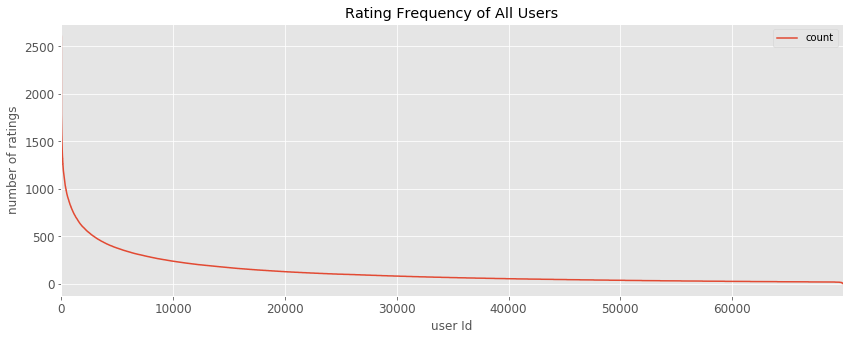

In [32]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(14, 5),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings");

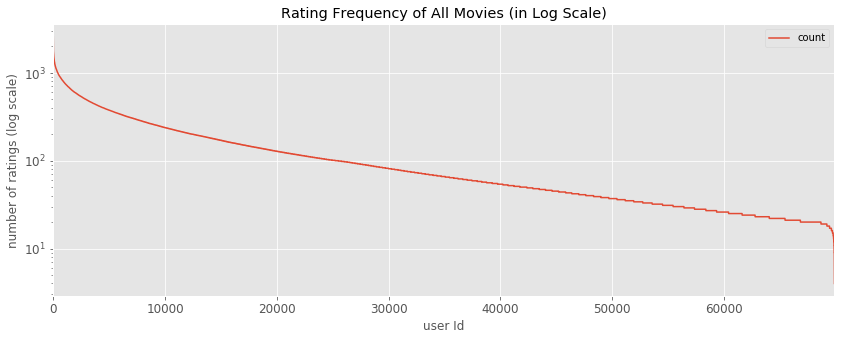

In [33]:
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(14, 5),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings (log scale)");

In [34]:
df_users_cnt['count'].quantile(np.arange(.75, 1, .01))

0.75    147.00
0.76    153.00
0.77    159.00
0.78    166.00
0.79    174.00
0.80    182.00
0.81    190.00
0.82    199.00
0.83    208.00
0.84    218.00
0.85    230.00
0.86    242.00
0.87    256.00
0.88    271.00
0.89    288.00
0.90    307.00
0.91    328.00
0.92    352.00
0.93    380.00
0.94    413.00
0.95    455.15
0.96    508.92
0.97    580.00
0.98    684.46
0.99    865.00
Name: count, dtype: float64

- We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. 

- Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [35]:
# filter data
ratings_thres = 50

active_users  = list(set(df_users_cnt.query('count >= @ratings_thres').index))

df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.user_id.isin(active_users)]

print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (10000054, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (8126186, 4)


# Train KNN model for item-based collaborative filtering

    Reshaping the Data
    Fitting the Model
    
#### 1. Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where 
- each row is a movie and 
- each column is a different user. 

To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. 

Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). 

Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [36]:
df_ratings_drop_users.shape

(8126186, 4)

In [37]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movie_id', 
                                             columns='user_id', 
                                             values='rating').fillna(0)

# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in enumerate(list(df_movies.set_index('movie_id').loc[movie_user_mat.index].title))
}

# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [38]:
movie_user_mat.sample(6)

user_id,5,7,8,10,11,12,13,14,17,18,...,71553,71554,71555,71557,71558,71559,71560,71562,71564,71565
movie_id,,,,,,,,,,,,,,,,,,,,,
2287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2065,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2541,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
330,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
len(movie_to_idx)

2735

In [40]:
movie_user_mat_sparse

<2735x42359 sparse matrix of type '<class 'numpy.float64'>'
	with 8126186 stored elements in Compressed Sparse Row format>

#### 2. Fitting the Model

In [41]:
%env JOBLIB_TEMP_FOLDER=/tmp

# define model
model_knn = NearestNeighbors(metric='cosine', 
                             algorithm='brute', 
                             n_neighbors=20, 
                             n_jobs=-1)

# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [42]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
            
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    
    if not match_tuple:
        print('Oops! No match is found')
        return
    
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
        
    return match_tuple[0][1]


In [43]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [44]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Prestige, The (2006), with distance of 0.5444272667988117
2: Casino Royale (2006), with distance of 0.5402506790611259
3: 300 (2007), with distance of 0.5287879334941702
4: No Country for Old Men (2007), with distance of 0.5187947177292869
5: Juno (2007), with distance of 0.5185508619142722
6: I Am Legend (2007), with distance of 0.5168366674218539
7: Bourne Ultimatum, The (2007), with distance of 0.4970640504933935
8: Indiana Jones and the Kingdom of the Crystal Skull (2008), with distance of 0.48869147397344936
9: WALLÂ·E (2008), with distance of 0.45408480411969654
10: Dark Knight, The (2008), with distance of 0.32840041082957394
